# Optimization of Maxwell-Boltzamnn shaped QAM for average power contrained AWGN channel

This Jupyter notebook implements optmization of the shaping paramater of the Maxwell-Boltzamnn distribution for QAM constellations using empirical mutual information (MI) calculations. The optimized constellations are validated using MI calculated using Gauss Hermite quadrature.

G. Böcherer, “Achievable rates for probabilistic shaping,” arXiv preprint
arXiv:1707.01134, Jul. 2017.

P. Jäckel, “A note on multivariate Gauss-Hermite quadrature,” 2005. [Online]. Available: http://www.jaeckel.org/ANoteOnMultivariateGaussHermiteQuadrature.pdf

**Note**: Ensure the required Python libraries (NumPy, SciPy, and Matplotlib) are installed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_hermite
from scipy.optimize import minimize, minimize_scalar, newton
from numpy import log2, sqrt, pi, exp
from scipy.integrate import quad


## Utility Functions

In [2]:
def db2pow(db):
    return 10 ** (db / 10)


def AWGN_AIR_num(const_alphabet_base, bit_labels, SNR_dB, px, Ns, Nruns):
    # Normalize probability distribution
    px = px / np.sum(px)

    # Normalize constellation symbols
    absx2 = np.abs(const_alphabet_base)**2
    input_symbols = const_alphabet_base / np.sqrt(np.dot(absx2, px))

    # Noise parameters
    N0 = 1 / (10**(SNR_dB / 10))
    sigma2 = N0 / 2
    sigma = np.sqrt(sigma2)

    # Get symbol counts via type approximation
    N_symbols = n_type_approximation(px, Ns)

    MIs = np.zeros(Nruns)
    BMIs = np.zeros(Nruns)

    for Nc in range(Nruns):
        # Generate complex AWGN noise
        n = sigma * (np.random.randn(Ns) + 1j * np.random.randn(Ns))

        # Construct input symbol indices based on type counts
        idx = np.repeat(np.arange(len(input_symbols)), N_symbols)
        np.random.shuffle(idx)

        tx_sym = input_symbols[idx]
        rx_sym = tx_sym + n

        # Compute conditional PDF p(y|x)
        pygx = (1 / np.sqrt(2 * np.pi * sigma2)) * np.exp(
            -np.abs(rx_sym[:, np.newaxis] - input_symbols[np.newaxis, :])**2 / (2 * sigma2)
        ).T  # Shape: (M, Ns)

        pyx = px[:, np.newaxis] * pygx
        pyc = np.sum(pyx, axis=0)
        pxgy = pyx / pyc

        IND = (idx, np.arange(Ns))
        Qxigyi = pxgy[IND]

        l2Qxigyi = np.log2(Qxigyi)
        Entropy = -np.mean(np.log2(px[idx]))
        MIs[Nc] = Entropy + np.mean(l2Qxigyi)

        # Compute bit metrics
        qbkigyi = bit_labels @ pxgy
        for k in range(bit_labels.shape[0]):
            bki = bit_labels[k, idx]
            bki0 = bki == 0
            qbkigyi[k, bki0] = 1 - qbkigyi[k, bki0]

        BMIs[Nc] = Entropy + np.sum(np.mean(np.log2(qbkigyi), axis=1))

    return MIs, BMIs, Entropy

def lambda2px(const_alphabet_base, lambd):
    # Maxwell-Boltzmann distribution
    P = np.exp(-lambd * np.abs(const_alphabet_base)**2)
    px_MB = P / np.sum(P)
    return px_MB

def Assign_labels(x, m):
    import numpy as np
    l = np.zeros(x.shape[0], dtype=int)
    i = np.argsort(x[:, 0])
    D = x.shape[1]
    if D == 1:
        l[i] = graymap(m[0])
    else:
        l_dim = graymap(m[0])
        for j in range(2**m[0]):
            Mj = 2**np.sum(m[1:])
            s = i[Mj*j : Mj*(j+1)]
            ls = Assign_labels(x[s, 1:], m[1:])
            l[s] = Mj * l_dim[j] + ls
    return l


def graymap(nbits):
    import numpy as np
    seq = np.array([[0], [1]])
    for i in range(2, nbits+1):
        seq = np.vstack((
            np.hstack((np.zeros((seq.shape[0], 1), dtype=int), seq)),
            np.hstack((np.ones((seq.shape[0], 1), dtype=int), np.flipud(seq)))
        ))
    return bit2int(seq.T, nbits)

def bit2int(bits, nbits):
    # Convert binary to integer
    weights = 2**np.arange(nbits-1, -1, -1)
    return np.dot(bits.T, weights)

def int2bit(int_array, nbits):
    """Convert integer array to binary matrix."""
    return ((int_array[:, None] & (1 << np.arange(nbits - 1, -1, -1))) > 0).astype(int).T



def n_type_approximation(P, n):
    Q = np.floor(n * P).astype(int)
    L = n - np.sum(Q)
    idx = np.argsort(P - Q / n)[::-1]
    Q[idx[:L]] += 1

    R = np.ceil(n * P).astype(int)
    L = np.sum(R) - n
    idx = np.argsort(R)[::-1]
    R[idx[:L]] -= 1

    return Q



In [3]:
def AWGN_AIR_GH(const_alphabet_base, px, bit_labels, SNR_dB):
    M = len(px)
    assert len(const_alphabet_base) == M

    # Normalize constellation to unit average power
    const_alphabet_base = const_alphabet_base / np.sqrt(np.mean(np.abs(const_alphabet_base) ** 2))
    const_alphabet_base = const_alphabet_base.reshape(1, M)
    px = np.array(px).reshape(M)
    px = px / np.sum(px)

    # print("px.shape",px.shape)

    # Normalize symbols using MB-like scaling
    absx2 = np.abs(const_alphabet_base) ** 2
    const_alphabet = const_alphabet_base / np.sqrt(np.dot(absx2, px))

    # Compute weights and conditional PDF
    wiui, pygx = SNR_init(const_alphabet, SNR_dB)


    px_3 = px.reshape(1, 1, M)  # Shape (1,1,M)
    pyx = pygx * px_3           # Element-wise multiply
    py = np.sum(pyx, axis=2)    # Marginal p(y)
    pxgy = pyx / py[..., np.newaxis]  # Conditional p(x|y)

    # Initialize MI and BMI
    BMI = -np.dot(np.log2(px), px)  # Entropy H(X)

    for k in range(bit_labels.shape[0]):
        for bk in [0, 1]:
            jdx = np.where(bit_labels[k, :] == bk)[0]
            for j in jdx:
                p = np.sum(pxgy[:, j, jdx], axis=1)  # Marginal over bit subset
                BMI += np.dot(wiui, np.log2(p)) * px[j]


    
    # Extract diagonal p(x|x, y)
    idx = np.arange(M)
    pxgy_diag = pyx[:, idx, idx] / py

    
    MI = -np.dot(np.log2(px), px) + np.dot(wiui, np.log2(pxgy_diag)) @ px


    return MI, BMI

def SNR_init(const_alphabet, SNR_dB):
    M = const_alphabet.size
    const_alphabet = const_alphabet.flatten()

    # Compute noise variance
    N0 = 1 / (10 ** (SNR_dB / 10))
    sigma2 = N0 / 2

    # Parameters for circularly-symmetric sampling (60 radial points)
    um = 60
    u = (np.arange(um)) / um

    # Radial points (ri) and weights (wi) - precomputed Gauss-Hermite nodes and weights
    ri = np.array([0.0181397005082948378524401474, 0.0606359722334330323317006934, 0.1269434513472307462286323953, 0.2164390131043138745139323638, 0.3283256911587094698388534981, 0.4616658202602770540639830571, 0.6154201396834196186952129424, 0.7884869819405788002346580245, 0.979738733830447933402399561, 1.1880538008120501643399841791, 1.4123431536218229101139772077, 1.6515712395921842703994918331, 1.904771563947685829268915732, 2.1710575826809929973046820647, 2.449629722534865140339086077, 2.7397793944698467868832898938, 3.0408908367045790425390712192, 3.3524415488348845819924663456, 3.6740019883494474860235892024, 4.0052351155523623394403232408, 4.3458963064471791543080867578, 4.6958341153718969959594744337, 5.0549923684127950183947999908, 5.4234141144254907919635562571, 5.8012480669123749816039341972, 6.1887583600945204377578260478, 6.5863387554766470920495281444, 6.9945329390186812994503066073, 7.4140633641907829256248431521, 7.8458724426464351475671330916, 8.2911821789522836171639462041, 8.7515824167468727264720025754, 9.2291654497390674136502960753, 9.7267397590937824085962892799, 10.2481876028098487334880310853, 10.7991058987248692647654543605, 11.3880671009604767374799558523, 12.0294527705330321028828364389, 12.751288602215954184995704258, 13.6271336705727514664042210761]) 
    wi = np.array([0.000551876060794132463437798, 0.003297993050650623346339405, 0.0098247443293383773861183424, 0.0213197818160926014655424573, 0.0381964199467010583331203923, 0.0596463767660520225561448392, 0.0833116256555750786657969072, 0.1053639045774873834547574373, 0.1212368550486425415148903206, 0.1269861621716086412296155692, 0.120821212136477049501418694, 0.1040335453362978029275591838, 0.0806823279849375942215256422, 0.0560536228597038006576852852, 0.0346821922991377926414411242, 0.0189938110858157461134119408, 0.0091482933459612646237567408, 0.0038495539939282763501754465, 0.0014055075882826572765171724, 0.00044206443593747073950697945506938608, 0.00011887143000050882037289754709155543, 0.00002710855612112422346256132486362821, 5.19757032784332648547461944516875e-6, 8.2994191291484321832721690290889e-7, 1.0922181385606142844350522158499e-7, 1.170873420375285772838005947202e-8, 1.00901722385835954271685601844e-9, 6.884455381213794868137709179e-11, 3.65363396001040353854831011e-12, 1.4769073431616414897320294e-13, 4.433853229326137326952819095434411e-15, 9.5836753583268964502920637072951e-17, 1.434385210500509804797670360023e-18, 1.4134698449768307106623297084e-20, 8.5720509945817582794588092e-23, 2.91072219783710282525084773487796e-25, 4.80650612787263249533472901977e-28, 3.06682460551722064991526966e-31, 4.89668065377803543144218543779782e-35, 6.554385589098533207251297335e-40])

    # Grid of circular points in complex plane
    x = ri[:, np.newaxis] * np.cos(2 * np.pi * u)
    y = ri[:, np.newaxis] * np.sin(2 * np.pi * u)
    rx = x + 1j * y  # Shape: (len(ri), len(u))
    rx = rx.flatten()  # Flatten to vector of shape (len(ri)*len(u),)

    # Apply channel noise to all symbols
    rx = const_alphabet[:, np.newaxis] + np.sqrt(sigma2) * rx[np.newaxis, :]
    rx = np.transpose(rx)


    # Calculate p(y|x) using Gaussian PDF
    c_3 = const_alphabet.reshape(1, 1, M)
    pygx = (1 / (2 * np.pi * sigma2)) * np.exp(-np.abs(np.expand_dims(rx,2) - c_3) ** 2 / (2 * sigma2))



    # Weights for numerical integration (outer product)
    wiui = np.kron(wi, np.ones(um) / um)

    return wiui, pygx




## Main Execution Loop

In [5]:
# M = 64
# real_vals = np.arange(-7, 8, 2)
# imag_vals = np.arange(-7, 8, 2)
# QAM64_alphabet = np.array([x + 1j*y for y in imag_vals for x in real_vals])
# QAM64_alphabet = QAM64_alphabet / np.sqrt(np.mean(np.abs(QAM64_alphabet)**2))

M = 256
real_vals = np.arange(-15, 16, 2)
imag_vals = np.arange(-15, 16, 2)
QAM256_alphabet = np.array([x + 1j*y for y in imag_vals for x in real_vals])
QAM256_alphabet = QAM256_alphabet / np.sqrt(np.mean(np.abs(QAM256_alphabet)**2))

const_alphabet_base = QAM256_alphabet
m = [4, 4]

# Prepare coordinates for labeling
x_coords = np.column_stack((np.real(const_alphabet_base), np.imag(const_alphabet_base)))
labels = Assign_labels(x_coords, m)
bit_labels = int2bit(labels, sum(m))  # Shape: (bits_per_symbol, M)

MI_GHs = []
MI_Ns = []
lam_opts = []

SNR_dB_list = np.arange(5,26)
for SNR_dB in SNR_dB_list:

    opt_fun = lambda lam : -AWGN_AIR_num(const_alphabet_base, bit_labels, SNR_dB, lambda2px(const_alphabet_base, lam), 2**15, 1)[0][0]
    opt_result = minimize_scalar(opt_fun,bounds=(0,200))
    lam_opt = opt_result.x

    MI_Ns.append(-opt_result.fun)
    lam_opts.append(lam_opt)

    MI_GH = AWGN_AIR_GH(const_alphabet_base, lambda2px(const_alphabet_base, lam_opt), bit_labels, SNR_dB)[0]

    MI_GHs.append(MI_GH)



In [6]:
MI_UNs = []
for SNR_dB in SNR_dB_list:
    MI_UNs.append(AWGN_AIR_GH(const_alphabet_base, lambda2px(const_alphabet_base, 0), bit_labels, SNR_dB)[0])

# Input: SNR values in dB
P = db2pow(SNR_dB_list)

# Shannon capacity bound
bound_shannon = np.log2(1 + P)

MB_MI_gap = bound_shannon - MI_GHs
UN_MI_gap = bound_shannon - MI_UNs


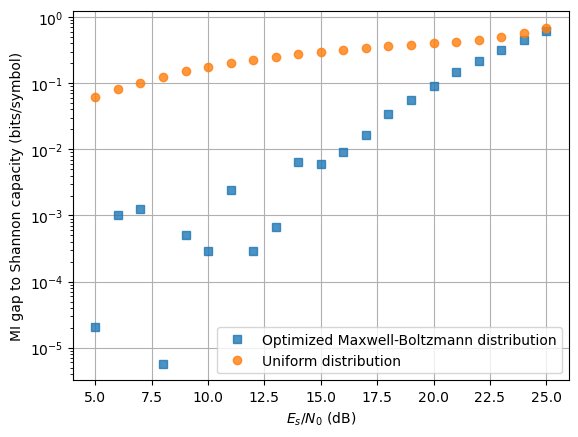

In [7]:

# Plotting results
plt.plot(SNR_dB_list, MB_MI_gap, 's', label='Optimized Maxwell-Boltzmann distribution',alpha=0.8)
plt.plot(SNR_dB_list, UN_MI_gap, 'o', label='Uniform distribution',alpha=0.8)
plt.xlabel('$E_s/N_0$ (dB)')
plt.ylabel('MI gap to Shannon capacity (bits/symbol)')
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.savefig("plots/AWGN_APC_256QAM_MI.png",dpi=600,bbox_inches="tight")
plt.show()

